# Multivariate Gaussian Anomaly Detection

In [27]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score,confusion_matrix,fbeta_score
import seaborn as sns

In [54]:
#tr_data = read_dataset('tr_server_data.csv') 
#cv_data = read_dataset('cv_server_data.csv') 
#gt_data = read_dataset('gt_server_data.csv')
import csv
a1 = 'data/tr_server_data.csv'
a2 ='data/cv_server_data.csv'
a3 = 'data/gt_server_data.csv'


raw_data = open(a2, 'rt')
reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
x = list(reader)
data = np.array(x).astype('float')

raw_data = open(a3, 'rt')
reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
x = list(reader)
gt_data = np.array(x).astype('float')

Number of datapoints in training set: 307
Number of dimensions/features: 2


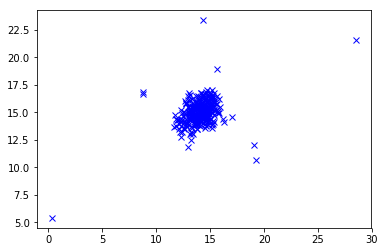

In [55]:
n_training_samples = data.shape[0]
n_dim = data.shape[1]

print('Number of datapoints in training set: %d' % n_training_samples)
print('Number of dimensions/features: %d' % n_dim)


# plt.xlabel('Latency (ms)')
# plt.ylabel('Throughput (mb/s)')
plt.plot(data[:,0],data[:,1],'bx')
plt.show()

In [56]:
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)    

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    p_pdf = p.pdf(dataset)
    return p_pdf

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):

        predictions = (probs < epsilon) 
        #print(predictions)
        f = f1_score(gt, predictions,average='binary')
        #print(f)
        #print('------')
        if f > best_f1:
            #print('----')
            best_f1 = f
            best_epsilon = epsilon
    
    return best_f1, best_epsilon

Gather a little more data and create a test set (another group of values) with labeled data. Labeled data means that you know if they were anomalies or not for each example in the set. Find at least a few examples which are anomalies. Make the predictions using a value of epsilon value (start with a low value). Calculate the F1 score for that epsilon (the F1 score of an epsilon is a value that tells you how accurate your predictions are with that epsilon ). The bigger the F1 , the better. Increment epsilon by a small value, calculate F1 for the new epsilon. Do this a couple of times and keep the epsilon with the best F1 score. Let’s see the math and an example:







In [57]:
mu, sigma = estimateGaussian(data)
print(mu, sigma )

[14.01929524 15.03773094] [[2.52609509 0.88154318]
 [0.88154318 1.63134612]]


In [58]:
p = multivariateGaussian(data,mu,sigma)

In [59]:
fscore, ep = selectThresholdByCV(p,gt_data)

/home/mihir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
#selecting outlier datapoints 

outliers = np.where(p < ep)
mvg = np.where(p < ep,1,0).reshape(data.shape[0],1)

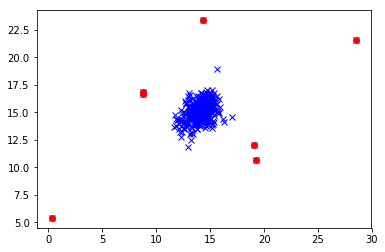

In [61]:
plt.figure()
# plt.xlabel('Latency (ms)')
# plt.ylabel('Throughput (mb/s)')
plt.plot(data[:,0],data[:,1],'bx')
plt.plot(data[outliers,0],data[outliers,1],'ro')
plt.show()

Text(91.68,0.5,'Predicted Labels')

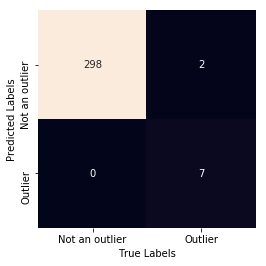

In [62]:
mat = confusion_matrix(np.array(gt_data),mvg)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,xticklabels=["Not an outlier","Outlier"],yticklabels=["Not an outlier","Outlier"])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

In [63]:
f1_score(gt_data,mvg,average='binary')

0.8750000000000001

In [64]:
fbeta_score(gt_data,mvg,0.5,average='binary')

0.945945945945946

## Anomaly Detection Using One-Class SVM

In [65]:
from sklearn import svm

In [66]:
data = read_dataset(a2)

In [67]:
clf = svm.OneClassSVM(nu=0.035, kernel="rbf", gamma=0.01)
clf.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01, kernel='rbf',
      max_iter=-1, nu=0.035, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [68]:
pred = clf.predict(data)

normal = np.where(pred == 1)
abnormal = np.where(pred == -1)
ocs = np.where(pred == -1,1,0).reshape(data.shape[0],1)

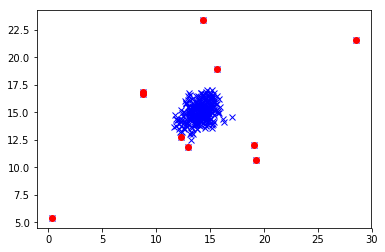

In [69]:
plt.figure()
# plt.xlabel('Latency (ms)')
# plt.ylabel('Throughput (mb/s)')
plt.plot(data[:,0],data[:,1],'bx')
plt.plot(data[abnormal,0],data[abnormal,1],'ro')
plt.show()

Text(91.68,0.5,'Predicted Labels')

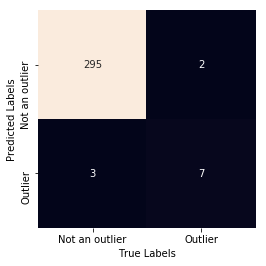

In [70]:
mat = confusion_matrix(np.array(gt_data),ocs)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,xticklabels=["Not an outlier","Outlier"],yticklabels=["Not an outlier","Outlier"])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

In [71]:
f1_score(gt_data,ocs,average='binary')

0.7368421052631577

In [72]:
fbeta_score(gt_data,ocs,0.5,average='binary')

0.7142857142857143

# Two Phase Clustering Anomaly Detection

In [73]:
from sklearn.cluster import KMeans

In [74]:
data = read_dataset(a2)

In [75]:
def twophase(data):
    kmeans = KMeans(n_clusters=1)  
    kmeans.fit(data)

    distances = []
    for d in data:
        dist = np.linalg.norm(np.array(d)-np.array(kmeans.cluster_centers_))
        distances.append(dist)
    distances = np.array(distances)
    print(np.var(distances))
    threshold = np.cov(distances)*np.mean(distances)
    print(threshold)
    outliers = np.where(distances>threshold)
    tpc = np.where(distances>threshold,1,0).reshape(data.shape[0],1)
    
    return outliers,tpc

In [76]:
outliers,tpc = twophase(data)

2.3184150846815315
3.142658243456782


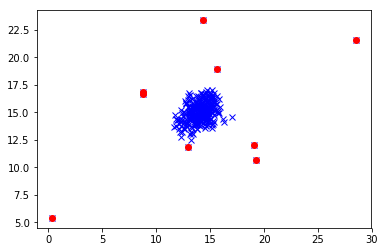

In [77]:
plt.figure()
# plt.xlabel('Latency (ms)')
# plt.ylabel('Throughput (mb/s)')
plt.plot(data[:,0],data[:,1],'bx')
plt.plot(data[outliers,0],data[outliers,1],'ro')
plt.show()

Text(91.68,0.5,'Predicted Labels')

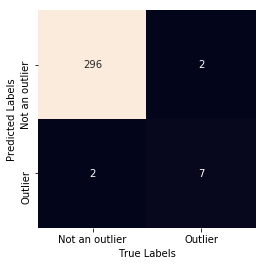

In [78]:
mat = confusion_matrix(np.array(gt_data),tpc)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,xticklabels=["Not an outlier","Outlier"],yticklabels=["Not an outlier","Outlier"])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')

In [79]:
f1_score(gt_data,tpc,average='binary')

0.7777777777777778

In [80]:
fbeta_score(gt_data,tpc,0.5,average='binary')

0.7777777777777778